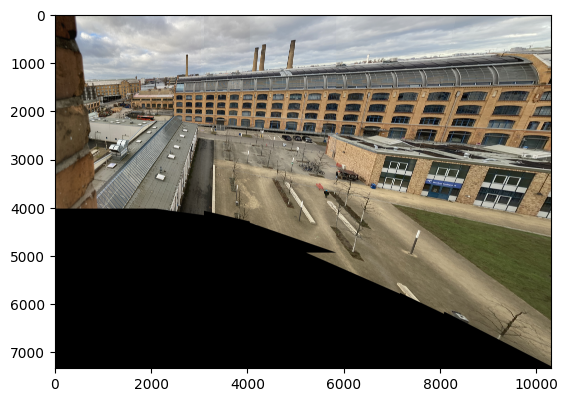

Die Rechendauer betrug:  40.607762575149536 Sekunden


In [12]:
import cv2
import glob
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

start_time = time.time()

def create_panorama(memoryAdress, imageFolder, cuttingsize):
    # Load Images from the folder
    images = glob.glob(imageFolder)

    # Use first image as starting point for panorama
    panorama = cv2.imread(images[0])

    # create SIFT-Objekt
    sift = cv2.SIFT_create()

    # Loop through all images
    for image in images[1:]:
        # Bild laden
        current_image = cv2.imread(image)

        # Find SIFT keypoints and descriptors for both images
        kp1, des1 = sift.detectAndCompute(panorama, None)
        kp2, des2 = sift.detectAndCompute(current_image, None)

        # Keypoints mit FLANN matchen
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)

        # Select valid matches
        good_matches = []
        for m, n in matches:
            if m.distance < 0.4*n.distance:
                good_matches.append(m)

        # Determine keypoints of valid matches
        if len(good_matches) > 9:
            panorama_points = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            current_image_points = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            # Homographie-Matrix bestimmen
            H, mask = cv2.findHomography(current_image_points, panorama_points, cv2.RANSAC, 5.0)




            # Set new size of the panorama
            panorama_width = panorama.shape[1] + current_image.shape[0]
            panorama_height = panorama.shape[0] + current_image.shape[0]

            # create the panorama
            result = cv2.warpPerspective(current_image, H, (panorama_width, panorama_height))
            result[0:panorama.shape[0], 0:panorama.shape[1]] = panorama

            panorama = result

            # Convert the panorama image to a PIL image
            pil_image = Image.fromarray(panorama)

            # Get the bounding box of the image
            image_box = pil_image.getbbox()

            # Crop the image using the bounding box
            cropped_image = pil_image.crop(image_box)

            # Convert the cropped image back to a NumPy array
            panorama = np.array(cropped_image)


            # Convert the panorama image to a PIL image
            pil_image = Image.fromarray(panorama)

            # Get the width and height of the image
            width, height = pil_image.size

            # Define the bounding box for the cropped image
            x1, y1, x2, y2 = 0, 0, width - cuttingsize, height

            # Crop the image using the bounding box
            cropped_image = pil_image.crop((x1, y1, x2, y2))

            # Convert the cropped image back to a NumPy array
            panorama = np.array(cropped_image)

    # Panorama speichern
    cv2.imwrite(memoryAdress, panorama)

create_panorama('output/panorama.jpeg', 'images/*', 660)
create_panorama('output/panorama2.jpeg', 'images2/*', 400)
create_panorama('panoramaRES.jpeg', 'output/*', 0)

panorama = plt.imread('panoramaRES.jpeg')
plt.imshow(panorama)
plt.show()

end_time = time.time()
total_time = end_time - start_time
print("Die Rechendauer betrug: ", total_time, "Sekunden")